<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Подготовка-к-обучению-моделей" data-toc-modified-id="Подготовка-к-обучению-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к обучению моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**_Признаки:_**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**_Целевой признак:_**

* Price — цена (евро)

## Подготовка данных

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    autos = pd.read_csv('home/an4ouce/datasets/autos.csv')

In [2]:
display(autos.head())
display(autos.info())
display(autos.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Сразу видим аномалию цены - ноль. Посмотрим, много ли таких объектов в датафрейме:

In [3]:
autos.columns = autos.columns.str.lower()

autos.query('price == 0')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


Имеет смысл удалить 10772 объекта, так как это наш целевой признак, и дополнительный шум нам не нужен.

In [4]:
autos = autos.query('price != 0')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          343597 non-null object
price                343597 non-null int64
vehicletype          309847 non-null object
registrationyear     343597 non-null int64
gearbox              326242 non-null object
power                343597 non-null int64
model                326076 non-null object
kilometer            343597 non-null int64
registrationmonth    343597 non-null int64
fueltype             314138 non-null object
brand                343597 non-null object
notrepaired          277731 non-null object
datecreated          343597 non-null object
numberofpictures     343597 non-null int64
postalcode           343597 non-null int64
lastseen             343597 non-null object
dtypes: int64(7), object(9)
memory usage: 44.6+ MB


Удалили. Теперь визуализируем количество пропусков по столбцам:

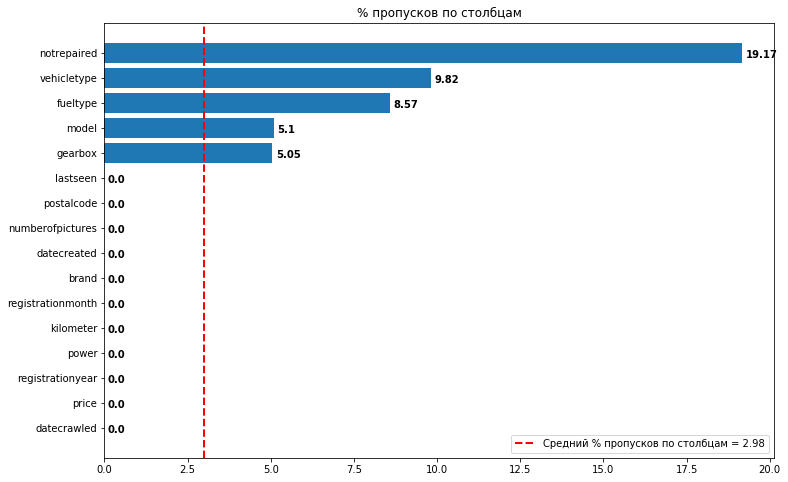

In [5]:
total_data = autos.shape[0]
columns_data = autos.columns.values.tolist()

nan = []

for col in columns_data:
    quantity_not_nan = autos[col].count()
    percent_nan = ((total_data - quantity_not_nan) / total_data) * 100
    nan.append(percent_nan)
    
nan_percent = pd.Series(nan, index=columns_data)
nan_percent_mean = nan_percent.mean()
nan_percent.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(nan_percent.index, nan_percent.values)
ax.set_title('% пропусков по столбцам')

#построим линию, показывающую средний % пропусков по столбцам
plt.axvline(
    x=nan_percent_mean, linewidth=2,
    label='Средний % пропусков по столбцам = {}'.format(round(nan_percent_mean, 2)),
    color='r', linestyle='--')

plt.legend()

for i in ax.patches:
    plt.text(i.get_width()+0.1,
    i.get_y()+0.2, str(round(i.get_width(),2)),
    fontsize=10, fontweight='bold', color='black')

plt.show()

Больше всего пропусков (19,17%) имеет столбец **notrepaired**. Корректно заполнить его мы не сможем, потому заполним пропуска значением 'unknown'. 

В столбце **vehicletype** пропусков меньше - 9,82%. Заменим пропуски на 'unknown'.

В столбце **fueltype** 8,57% пропусков. Большинство автомобилей на бензине, гибриды и электрокары появились совсем недавно, потому логично заменить пропуски на 'petrol'.

Столбцы **model** и **gearbox** содержат 5,1% и 5,05% пропусков соответственно. Заполним 'unknown', так как никак не определить, на механике автомобиль или на автомате, да и модель по другим признакам тоже.

In [6]:
change_list = ['notrepaired', 'vehicletype', 'model', 'gearbox']
for col in change_list:
    autos[col].fillna('unknown', inplace=True)

In [7]:
autos['fueltype'].value_counts()

petrol      210765
gasoline     97168
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: fueltype, dtype: int64

Действительно, как и предполагалось, большинство автомобилей на бензине. Заменим пропуски на 'petrol':

In [8]:
autos['fueltype'].fillna('petrol', inplace=True)
autos['fueltype'].isna().sum()

0

In [9]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          343597 non-null object
price                343597 non-null int64
vehicletype          343597 non-null object
registrationyear     343597 non-null int64
gearbox              343597 non-null object
power                343597 non-null int64
model                343597 non-null object
kilometer            343597 non-null int64
registrationmonth    343597 non-null int64
fueltype             343597 non-null object
brand                343597 non-null object
notrepaired          343597 non-null object
datecreated          343597 non-null object
numberofpictures     343597 non-null int64
postalcode           343597 non-null int64
lastseen             343597 non-null object
dtypes: int64(7), object(9)
memory usage: 44.6+ MB


Пропущенные значения заполнили. Теперь займемся поиском аномалий.

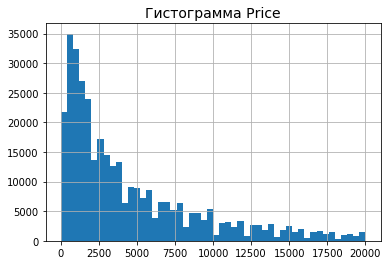

In [10]:
autos['price'].hist(bins=50)
plt.title('Гистограмма Price', fontsize=14)
plt.show()

Взглянем поближе:

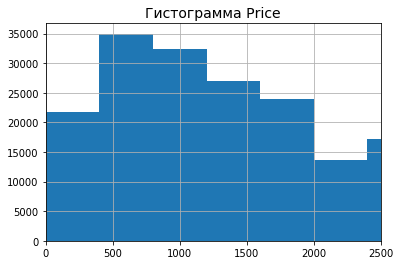

In [11]:
autos['price'].hist(bins=50)
plt.title('Гистограмма Price', fontsize=14)
plt.xlim(0, 2500)
plt.show()

Порядка 22000 автомобилей с ценой до 400 евро. Посмотрим на боксплот:

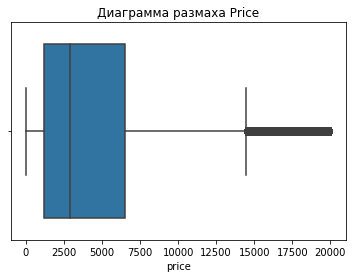

In [12]:
sns.boxplot(autos['price'])
plt.title('Диаграмма размаха Price')
plt.show()

Значения до 400 евро похожи на выбросы, значения свыше 15000 евро - уже нет; скорее всего, там собраны элитные автомобили. Удалим из датафрема объекты с ценой менее 400 евро:

In [13]:
autos = autos.query('price > 400')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321908 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          321908 non-null object
price                321908 non-null int64
vehicletype          321908 non-null object
registrationyear     321908 non-null int64
gearbox              321908 non-null object
power                321908 non-null int64
model                321908 non-null object
kilometer            321908 non-null int64
registrationmonth    321908 non-null int64
fueltype             321908 non-null object
brand                321908 non-null object
notrepaired          321908 non-null object
datecreated          321908 non-null object
numberofpictures     321908 non-null int64
postalcode           321908 non-null int64
lastseen             321908 non-null object
dtypes: int64(7), object(9)
memory usage: 41.8+ MB


В датафрейме также есть аномалия нуля в столбце **power**. Рассмотрим подробнее:

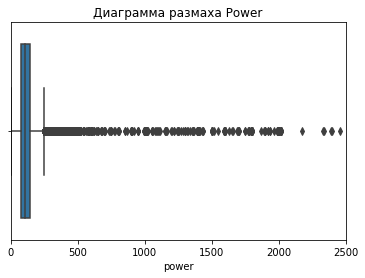

In [14]:
sns.boxplot(autos['power'])
plt.title('Диаграмма размаха Power')
plt.xlim(0,2500)
plt.show()

В нашем датафрейме есть автомобиль Trabant, его мощность 23 л.с. Будем считать его самым маломощным. Что касается самого мощного - едва ли обычные серийные автомобили превышают мощность в 500 л.с. По диаграмме размаха видно, что значения свыше 550 л.с. уже можно считать выбросами. Удалим значения до 23 л.с. и свыше 550 л.с.:

In [15]:
autos = autos.query('23 <= power < 550')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291619 entries, 1 to 354368
Data columns (total 16 columns):
datecrawled          291619 non-null object
price                291619 non-null int64
vehicletype          291619 non-null object
registrationyear     291619 non-null int64
gearbox              291619 non-null object
power                291619 non-null int64
model                291619 non-null object
kilometer            291619 non-null int64
registrationmonth    291619 non-null int64
fueltype             291619 non-null object
brand                291619 non-null object
notrepaired          291619 non-null object
datecreated          291619 non-null object
numberofpictures     291619 non-null int64
postalcode           291619 non-null int64
lastseen             291619 non-null object
dtypes: int64(7), object(9)
memory usage: 37.8+ MB


Также видим аномалии в годах регистрации автомобилей: минимальное значение 1000, максимальное 9999. Будем считать минимальным годом регистрации год начала продаж Trabant - 1957. Максимальным годом будем считать дату создания анкеты:

In [16]:
autos['datecreated'].max()

'2016-04-07 00:00:00'

Удалим все значения раньше 1957 года и позже 2016 года:

In [17]:
autos = autos.query('1957 <= registrationyear <= 2016')
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281601 entries, 1 to 354368
Data columns (total 16 columns):
datecrawled          281601 non-null object
price                281601 non-null int64
vehicletype          281601 non-null object
registrationyear     281601 non-null int64
gearbox              281601 non-null object
power                281601 non-null int64
model                281601 non-null object
kilometer            281601 non-null int64
registrationmonth    281601 non-null int64
fueltype             281601 non-null object
brand                281601 non-null object
notrepaired          281601 non-null object
datecreated          281601 non-null object
numberofpictures     281601 non-null int64
postalcode           281601 non-null int64
lastseen             281601 non-null object
dtypes: int64(7), object(9)
memory usage: 36.5+ MB


Проверим датафрейм на дубликаты:

In [18]:
autos.duplicated().sum()

4

Удалим их:

In [19]:
autos.drop_duplicates(inplace=True)
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281597 entries, 1 to 354368
Data columns (total 16 columns):
datecrawled          281597 non-null object
price                281597 non-null int64
vehicletype          281597 non-null object
registrationyear     281597 non-null int64
gearbox              281597 non-null object
power                281597 non-null int64
model                281597 non-null object
kilometer            281597 non-null int64
registrationmonth    281597 non-null int64
fueltype             281597 non-null object
brand                281597 non-null object
notrepaired          281597 non-null object
datecreated          281597 non-null object
numberofpictures     281597 non-null int64
postalcode           281597 non-null int64
lastseen             281597 non-null object
dtypes: int64(7), object(9)
memory usage: 36.5+ MB


Для построения моделей не важны следующие параметры: дата создания анкеты, месяц регистрации автомобиля, дата скачивания анкеты из базы, количество фотографий автомобиля, почтовый код владельца анкеты, дата последней активности пользователя. Удалим эти столбцы, чтобы избежать лишнего шума в моделях. 

In [20]:
autos = autos.drop(['lastseen', 'postalcode', 'numberofpictures', 'datecreated', 'registrationmonth',
                                                                              'datecrawled'], axis=1)

Теперь проверим числовые признаки на мультиколлинеарность:

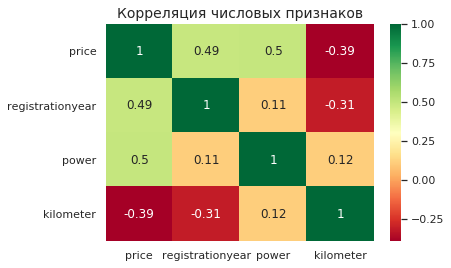

In [21]:
numeric = autos.drop(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'], axis=1)
sns.set(font_scale=1)
sns.heatmap(numeric.corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков', fontsize=14)

plt.show()

Мультиколлинеарности нет. Как и ожидалось - больше всего на цену автомобиля влияет год регистрации и мощность.

**Вывод:** мы хорошо поработали над сырыми данными, обработали пропуска и удалили аномальные значения, лишние признаки. Теперь можно заняться дальнейшей подготовкой признаков для обучения моделей.

## Подготовка к обучению моделей

Для прогнозирования цены автомобиля будем использовать следующие модели:

* **LinearRegression**,
* **Ridge**,
* **LGBMRegression**,
* **CatBoostRegression**

Для моделей LinearRegression и Ridge воспользуемся методом OHE(One-hot encoding) для кодирования категориальных признаков. Затем разобьем данные на обучающую и тестовую выборки в пропорции 80/20.

In [22]:
autos_ohe = pd.get_dummies(autos, drop_first=True)

target_linear = autos_ohe['price']
features_linear = autos_ohe.drop('price', axis=1)

features_train_linear, features_test_linear, target_train_linear, target_test_linear = train_test_split(
                                      features_linear, target_linear, test_size=0.2, random_state = 123)

print('Размер таблицы признаков обучающей выборки: ', features_train_linear.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_linear.shape)

Размер таблицы признаков обучающей выборки:  (225277, 309)
Размер таблицы признаков тестовой выборки:  (56320, 309)


Теперь можно выполнить масштабирование числовых признаков:

In [23]:
scaler = StandardScaler()

numerical = ['registrationyear', 'power', 'kilometer']

scaler.fit(features_train_linear[numerical])

features_train_linear[numerical] = scaler.transform(features_train_linear[numerical])
features_test_linear[numerical] = scaler.transform(features_test_linear[numerical])

features_train_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_unknown,notrepaired_yes
243126,-0.010656,-0.143067,0.601116,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
220890,0.459898,0.754205,0.601116,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153765,-0.481211,3.427327,0.601116,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139464,1.087304,1.520624,-1.029226,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114925,1.401007,-0.329998,-1.572673,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Видим, что кодирование и масштабирование проведены успешно.

Модели градиентного бустинга не нуждаются в кодировании категориальных признаков, но не умеют работать с типом object. Изменим тип категориальных признаков на category, чтобы модели могли с ними работать:

In [24]:
categorical = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

for col in categorical:
    autos[col] = autos[col].astype('category')

autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281597 entries, 1 to 354368
Data columns (total 10 columns):
price               281597 non-null int64
vehicletype         281597 non-null category
registrationyear    281597 non-null int64
gearbox             281597 non-null category
power               281597 non-null int64
model               281597 non-null category
kilometer           281597 non-null int64
fueltype            281597 non-null category
brand               281597 non-null category
notrepaired         281597 non-null category
dtypes: category(6), int64(4)
memory usage: 12.6 MB


Снова разобьем данные на обучающую и тестовую выборки:

In [25]:
target_boost = autos['price']
features_boost = autos.drop('price', axis=1)

features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
                                      features_boost, target_boost, test_size=0.2, random_state = 123)

print('Размер таблицы признаков обучающей выборки: ', features_train_boost.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_boost.shape)

Размер таблицы признаков обучающей выборки:  (225277, 9)
Размер таблицы признаков тестовой выборки:  (56320, 9)


Выполним масштабирование числовых признаков:

In [26]:
scaler.fit(features_train_boost[numerical])

features_train_boost[numerical] = scaler.transform(features_train_boost[numerical])
features_test_boost[numerical] = scaler.transform(features_test_boost[numerical])

features_train_boost.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
243126,convertible,-0.010656,manual,-0.143067,beetle,0.601116,petrol,volkswagen,no
220890,wagon,0.459898,auto,0.754205,3er,0.601116,gasoline,bmw,no
153765,coupe,-0.481211,auto,3.427327,cl,0.601116,petrol,mercedes_benz,no
139464,sedan,1.087304,auto,1.520624,5er,-1.029226,gasoline,bmw,no
114925,sedan,1.401007,manual,-0.329998,leon,-1.572673,gasoline,seat,unknown


Видим, что числовые признаки отмасштабированы, а категориальные переведены в тип category.

Напишем функцию, которая будет считать время обучения и время предсказания, а также RMSE моделей:

In [27]:
def model_final(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return train_time, predict_time, rmse

**Вывод:** подготовка к обучению моделей завершена. Для каждой модели учтены особенности: 

- линейные модели - сделано кодирование категориальных признаков (OHE) и масштабирование числовых;
- модели бустинга - категориальные признаки переведены в тип category, числовые масштабированы.

## Обучение моделей

Займемся обучением наших моделей: подберем оптимальные гиперпараметры с помощью GridSearchCV, проверим на тестовой выборке.

In [28]:
model = LinearRegression()

search_space_linear = [{'fit_intercept': [True, False],
                        'normalize': [True, False]}]


gs_linear = GridSearchCV(model, 
                        search_space_linear, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_linear, predict_time_linear, rmse_linear = model_final(gs_linear, features_train_linear, 
                                                                               target_train_linear,
                                                                              features_test_linear, 
                                                                                target_test_linear)

print('Linear Regression:')
print('Время обучения: ', round(train_time_linear, 2), 'сек')
print('Время предсказания: ', round(predict_time_linear, 2), 'сек')
print('RMSE модели: ', round(rmse_linear, 2), 'евро')

Linear Regression:
Время обучения:  431.29 сек
Время предсказания:  0.12 сек
RMSE модели:  2534.74 евро


In [29]:
model = Ridge()

search_space_ridge = [{'fit_intercept': [True, False],
                       'normalize': [True, False],
                       'alpha': np.linspace(1, 3, num = 5)}]


gs_ridge = GridSearchCV(model, 
                        search_space_ridge, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_ridge, predict_time_ridge, rmse_ridge = model_final(gs_ridge, features_train_linear,
                                                                           target_train_linear,
                                                                          features_test_linear,
                                                                            target_test_linear)

print('Ridge:')
print('Время обучения: ', round(train_time_ridge, 2), 'сек')
print('Время предсказания: ', round(predict_time_ridge, 2), 'сек')
print('RMSE модели: ', round(rmse_ridge, 2), 'евро')

Ridge:
Время обучения:  443.89 сек
Время предсказания:  0.3 сек
RMSE модели:  2534.57 евро


In [30]:
model = LGBMRegressor(categorical_feature=categorical)

search_space_lgbm = [{'learning_rate': [0.05, 0.1],
                       'n_estimators': [100, 200],
                       'num_leaves': [31, 62]}]


gs_lgbm = GridSearchCV(model, 
                        search_space_lgbm, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_lgbm, predict_time_lgbm, rmse_lgbm = model_final(gs_lgbm, features_train_boost, target_train_boost,
                                                                       features_test_boost, target_test_boost)

print('LGBMRegressor:')
print('Время обучения: ', round(train_time_lgbm, 2), 'сек')
print('Время предсказания: ', round(predict_time_lgbm, 2), 'сек')
print('RMSE модели: ', round(rmse_lgbm, 2), 'евро')

LGBMRegressor:
Время обучения:  521.99 сек
Время предсказания:  2.02 сек
RMSE модели:  1510.89 евро


In [31]:
model = CatBoostRegressor(loss_function='RMSE', silent=True, cat_features=categorical)

search_space_catboost = [{'learning_rate': [0.03, 0.1],
                          'iterations': [40, 60, 80],
                          'depth': [4, 6, 8]}]


gs_catboost = GridSearchCV(model, 
                        search_space_catboost, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        scoring='neg_mean_squared_error')

train_time_catboost, predict_time_catboost, rmse_catboost = model_final(gs_catboost, features_train_boost,
                                                                                       target_train_boost,
                                                                                      features_test_boost,
                                                                                        target_test_boost)

print('CatBoost:')
print('Время обучения: ', round(train_time_catboost, 2), 'сек')
print('Время предсказания: ', round(predict_time_catboost, 2), 'сек')
print('RMSE модели: ', round(rmse_catboost, 2), 'евро')

CatBoost:
Время обучения:  1714.31 сек
Время предсказания:  0.09 сек
RMSE модели:  1705.47 евро


## Анализ моделей

Для того, чтобы выснить, хорошо ли отрабатывают наши модели, нужно сравнить их с простой моделью. Воспользуемся DummyRegressor:

In [32]:
dummy = DummyRegressor(strategy='mean')

train_time_dummy, predict_time_dummy, rmse_dummy = model_final(dummy, features_train_linear, target_train_linear,
                                                                       features_test_linear, target_test_linear)

print('Dummy:')
print('Время обучения: ', round(train_time_dummy, 2), 'сек')
print('Время предсказания: ', round(predict_time_dummy, 2), 'сек')
print('RMSE модели: ', round(rmse_dummy, 2), 'евро')

Dummy:
Время обучения:  0.0 сек
Время предсказания:  0.0 сек
RMSE модели:  4589.04 евро


Сведем результаты работы наших моделей в таблицу:

In [33]:
data = {'Время обучения':[train_time_linear, train_time_ridge, train_time_lgbm, train_time_catboost,
                          train_time_dummy],
        
        'Время предсказания':[predict_time_linear, predict_time_ridge, predict_time_lgbm, predict_time_catboost,
                              predict_time_dummy],
        
       'RMSE':[rmse_linear, rmse_ridge, rmse_lgbm, rmse_catboost, rmse_dummy]}

table = pd.DataFrame(data)
table.index = ['LinearRegression', 'Ridge', 'LGBMRegressor', 'CatBoostRegressor', 'DummyRegressor']
pd.set_option('display.float_format', '{:.2f}'.format)
display(table)

,Время обучения,Время предсказания,RMSE
LinearRegression,431.29,0.12,2534.74
Ridge,443.89,0.30,2534.57
LGBMRegressor,521.99,2.02,1510.89
CatBoostRegressor,1714.31,0.09,1705.47
DummyRegressor,0.00,0.00,4589.04


Дамми-модель однозначно проигрывает. 
Сравним с медианной ценой автомобиля:

In [34]:
autos['price'].median()

3499.0

**Вывод:** рассмотрели четыре модели (две линейных и две модели градиентного бустинга), измерили RMSE, время обучения и предсказания. В результате сравнения с константной моделью получили, что любая из наших моделей более предсказуема.

## Общий вывод

Заказчику важны все три параметра: минимальная RMSE, скорость обучения и предсказания. Но невозможно достичь минимума сразу по всем параметрам, поэтому нужно выбрать, что важнее. Учитывая медианную цену в 3499 евро, модели линейной регрессии и Ridge недостаточно предсказуемы. Будем рассматривать LGBMRegressor и CatBoostRegressor. Минимум RMSE у LGBMRegressor (1510,89 евро) и эта модель довольно быстро обучается, но предсказывает медленнее всех. У CatBoostRegressor метрика RMSE на 12% выше, чем у LGBMRegressor; обучается модель в два раза медленнее LGBMRegressor, но предсказывает быстрее всех моделей. В целом, обе модели поставленную задачу выполняют, решение за заказчиком.